In [ ]:


!pip install scikit-learn xgboost pandas numpy

In [ ]:
!pip install torch==1.12.1+cu116 torchvision==0.13.1+cu116 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu116

In [ ]:
import torch
if torch.cuda.is_available():
    print(f"GPU count: {torch.cuda.device_count()}")
    print(f"Curren GPU Device ID: {torch.cuda.current_device()}")
else:
    print("No GPU")

# 套件匯入
---

In [1]:
'''
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
https://www.kaggle.com/code/stuarthallows/using-xgboost-with-scikit-learn/notebook
https://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html
https://medium.com/@zector1030/pandas-fillna-%E7%AF%84%E4%BE%8B-5d33819fb7b8
https://scikit-learn.org/stable/modules/impute.html
'''
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from pprint import pprint
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.inspection import permutation_importance
import xgboost as xgb
from xgboost import plot_importance, plot_tree, to_graphviz

import warnings
warnings.filterwarnings('ignore')

# EDA
---

In [2]:
'''
面對 missing values 議題
'''
# 額外測試 missing values 是否被填補 (透過欄位平均值)
df = pd.read_csv('./train_jan06_task4bonus.csv', low_memory=False)

In [ ]:
df.isnull().sum()

In [3]:
print('A:', len(df[ df["class"] == 'A' ].index))
print('B:', len(df[ df["class"] == 'B' ].index))
print('C:', len(df[ df["class"] == 'C' ].index))
print('D:', len(df[ df["class"] == 'D' ].index))

A: 1000
B: 2000
C: 2500
D: 1000


In [4]:
df[ df['class'] == 'A' ].isnull().sum()

feature0     66
feature1     64
feature2     62
feature3     61
feature4     66
feature5     74
feature6     63
feature7     52
feature8     59
feature9     75
feature10    72
feature11    67
feature12    63
feature13    57
class         0
dtype: int64

In [5]:
df[ df['class'] == 'B' ].isnull().sum()

feature0     132
feature1     113
feature2     110
feature3     126
feature4     128
feature5     112
feature6     127
feature7     108
feature8     112
feature9     117
feature10    134
feature11    110
feature12    136
feature13    136
class          0
dtype: int64

In [6]:
df[ df['class'] == 'C' ].isnull().sum()

feature0     153
feature1     149
feature2     150
feature3     127
feature4     149
feature5     169
feature6     145
feature7     130
feature8     135
feature9     170
feature10    154
feature11    161
feature12    147
feature13    152
class          0
dtype: int64

In [7]:
df[ df['class'] == 'D' ].isnull().sum()

feature0     64
feature1     67
feature2     75
feature3     54
feature4     67
feature5     54
feature6     61
feature7     51
feature8     66
feature9     71
feature10    62
feature11    65
feature12    63
feature13    69
class         0
dtype: int64

# 實際操作
---

In [ ]:
'''
SimpleImputer(strategy='mean'), df.iloc[:, 0:14].values
{'n_estimators': 195, 'max_depth': 6, 'learning_rate': 0.16, 'colsample_bytree': 0.76}

SimpleImputer(strategy='mean'), df.iloc[:, 0:14].values, Over-sampling
{'n_estimators': 34, 'max_depth': 196, 'learning_rate': 0.11, 'colsample_bytree': 0.68}

SimpleImputer(strategy='mean'), df.iloc[:, 0:14].values, Under-sampling
{'n_estimators': 35, 'max_depth': 105, 'learning_rate': 0.17, 'colsample_bytree': 0.98}
'''

'''
KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean'), df.iloc[:, 0:14].values
{'n_estimators': 32, 'max_depth': None, 'learning_rate': 0.15, 'colsample_bytree': 0.82}

KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean'), df.iloc[:, 0:14].values, Over-sampling
{'n_estimators': 38, 'max_depth': 164, 'learning_rate': 0.17, 'colsample_bytree': 0.65}

KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean'), df.iloc[:, 0:14].values, Under-sampling
{'n_estimators': 32, 'max_depth': None, 'learning_rate': 0.15, 'colsample_bytree': 0.82}
'''

'''
SimpleImputer(strategy='mean'), features = [3,0,1,6,4,2,5,9,8,13,7,11,12]
{'n_estimators': 36, 'max_depth': 76, 'learning_rate': 0.15, 'colsample_bytree': 0.85}

SimpleImputer(strategy='mean'), features = [3,0,1,6,4,2,5,9,8,13,7,11]
{'n_estimators': 40, 'max_depth': 232, 'learning_rate': 0.13, 'colsample_bytree': 0.8}

SimpleImputer(strategy='mean'), features = [3,0,1,6,4,2,5,9,8,13,7]
{'n_estimators': 34, 'max_depth': 98, 'learning_rate': 0.2, 'colsample_bytree': 0.82}

SimpleImputer(strategy='mean'), features = [3,0,1,6,4,2,5,9,8,13]
{'n_estimators': 34, 'max_depth': 98, 'learning_rate': 0.2, 'colsample_bytree': 0.82}

SimpleImputer(strategy='mean'), features = [3,0,1,6,4,2,5,9,8]
{'n_estimators': 34, 'max_depth': 98, 'learning_rate': 0.2, 'colsample_bytree': 0.82}
'''

'''
SimpleImputer(strategy='mean'), features = [3,0,1,6,4,2,5], Over-sampling
{'n_estimators': 34, 'max_depth': 98, 'learning_rate': 0.2, 'colsample_bytree': 0.82}
{'n_estimators': 90, 'max_depth': 187, 'learning_rate': 0.18, 'colsample_bytree': 0.91}

SimpleImputer(strategy='mean'), features = [3,0,1,6,4,2,5], Under-sampling
{'n_estimators': 99, 'max_depth': 22, 'learning_rate': 0.13, 'colsample_bytree': 0.91}
{'n_estimators': 228, 'max_depth': 988, 'learning_rate': 0.25, 'colsample_bytree': 0.87}
'''

In [29]:
'''
筆記:
weights = total_samples / (n_classes * class_samples * 1.0)

A類別權重 = 6500 / (4 * 1000 * 1.0) = 6500 / 4000 = 1.625
B類別權重 = 6500 / (4 * 2000 * 1.0) = 6500 / 8000 = 0.8125
C類別權重 = 6500 / (4 * 2500 * 1.0) = 6500 / 10000 = 0.65
D類別權重 = 6500 / (4 * 1000 * 1.0) = 6500 / 4000 = 1.625
'''

features = [3,0,1,6,4,2,5]

'''
主要函式
'''
# 切割資料
def split_data():
    global features
    
    try:
        '''
        https://scikit-learn.org/stable/modules/impute.html
        '''
        # 取得訓練資料
        df = pd.read_csv('./train_jan06_task4bonus.csv')
        imp = KNNImputer(n_neighbors=10, weights='uniform', metric='nan_euclidean')
        X = df.iloc[:, features].values # 0:14
        X = imp.fit_transform(X)
        y = df['class'].values
        
        # 將 label 的順序，從文字轉成數字格式
        Ly = LabelEncoder()
        y = Ly.fit_transform(y)
        print(y)
        print(Ly.classes_)
    
        # 切割資料
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        print(X_train.shape)

        # 過取樣 (Over-sampling)
        X_train, y_train = SMOTE().fit_resample(X_train, y_train)
        print(X_train.shape)
        
#         # 欠取樣 (Under-sampling)
#         X_train, y_train = TomekLinks().fit_resample(X_train, y_train)
#         print(X_train.shape)

        # 取得樣本的權重
        sample_weight_vect_y = class_weight.compute_sample_weight(
            class_weight = 'balanced',
            y = y
        )
        sample_weight_vect_y_train = class_weight.compute_sample_weight(
            class_weight = 'balanced',
            y = y_train
        )
        sample_weight_vect_y_test = class_weight.compute_sample_weight(
            class_weight = 'balanced',
            y = y_test
        )
        
        # 回傳切割結果
        return X, y, X_train, X_test, y_train, y_test, sample_weight_vect_y, sample_weight_vect_y_train, sample_weight_vect_y_test
    except Exception as err:
        print(str(err))
          
                         
# 訓練切割後的資料，並儲存模型
def train(X_train, X_test, y_train, y_test):
    try:
        '''
        colsample_bytree=0.95, learning_rate=0.04, max_depth=615, n_estimators=812;, score=0.930
        colsample_bytree=1.0, learning_rate=0.01, max_depth=895, n_estimators=981;, score=0.918
        colsample_bytree=0.75, learning_rate=0.02, max_depth=980, n_estimators=1300;, score=0.921
        colsample_bytree=0.93, learning_rate=0.02, max_depth=120, n_estimators=1450;, score=0.928
        colsample_bytree=0.93, learning_rate=0.07, max_depth=1035, n_estimators=951;, score=0.925
        '''
        # 分類器初始化，設定模型參數
        xgb_model = xgb.XGBClassifier(
            n_estimators = 951,
            max_depth = 1035,
            learning_rate = 0.07,
            colsample_bytree = 0.93,
            
            objective = 'multi:softprob',
            random_state = 42,
            n_jobs = 8
        )

        # 訓練模型
        xgb_model.fit(
            X_train, 
            y_train, 
            eval_metric="mlogloss", 
            early_stopping_rounds=5, 
            eval_set=[(X_test, y_test)],
            verbose=True
        )
        
        # 預測結果
        y_pred = xgb_model.predict(X_test)
        
        # 儲存 model
        xgb_model.save_model("task04_model.json")
        
        # 回傳 model 跟 測試資料的預測結果
        return xgb_model, y_pred
    except Exception as err:
        print(str(err))
    
# 預測結果
def predict():
    global xgb_model, features
    
    try:
        # 讀取模型
        xgb_model.load_model("task04_model.json")
        
        # 讀取測試集
        df = pd.read_csv('./test_jan06_task4bonus.csv')
        imp = KNNImputer(n_neighbors=10, weights='uniform', metric='nan_euclidean')
#         imp = SimpleImputer(strategy='mean')
        X = df.iloc[:, features].values #:14
        X = imp.fit_transform(X)
        
        # 進行預測
        y_pred = xgb_model.predict(X)
        
        # 建立 submission 資料
        dict_headers = {
            "Id": [(x + 1) for x in range(len(y_pred))],
            "Category": y_pred
        }
        
        # 將 dict 轉成 dataframe，並檢視結果
        df = pd.DataFrame(dict_headers)
        df['Category'] = df['Category'].replace([0], 'A')
        df['Category'] = df['Category'].replace([1], 'B')
        df['Category'] = df['Category'].replace([2], 'C')
        df['Category'] = df['Category'].replace([3], 'D')
        print(df)
        
        # 儲存成 csv，以便上傳結果至 kaggle
        df.to_csv('submission_task04.csv', index=False)
    except Exception as err:
        print(str(err))
        
        
'''
檢視設定與結果
'''
# 取得最佳參數
def show_best_params(X_train, y_train):
    try:
        # 分類器初始化
        xgb_model = xgb.XGBClassifier(
            objective = 'multi:softprob',
            random_state = 42,
        )
        
        # 參數範圍初始化
        n_estimators = [int(x) for x in np.linspace(start=10, stop=1500, num=300)]
        max_depth = [int(x) for x in np.linspace(start=6, stop=1500, num=300)]
        max_depth.append(None)
        learning_rate=[round(float(x),2) for x in np.linspace(start=0.001, stop=0.1, num=200)]
        colsample_bytree =[round(float(x),2) for x in np.linspace(start=0.1, stop=1, num=100)]
        
        # 尋找合適參與的資料格式
        random_grid = {
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'learning_rate': learning_rate,
            'colsample_bytree': colsample_bytree
        }
        
        # 透過交叉驗證來取得參數
        xg_random = RandomizedSearchCV(
            estimator = xgb_model, 
            param_distributions = random_grid, 
            n_iter = 500, 
            cv = 10, 
            verbose = 3, 
            random_state = 42, 
            n_jobs = -1
        )
        
        # 透過訓練來尋找合適參數組合
        xg_random.fit(X_train, y_train)
        
        print(xg_random.best_params_)
        
    except Exception as err:
        print(str(err))

# 計算各項評估分數
def show_scores(m, x_train, x_test, y_train, y_test, train=True):
    try:
        if train: # 計算 使用訓練資料 的評估結果
            pred = m.predict(x_train)
            print('Train Result:')
            print(f"- Accuracy Score: {accuracy_score(y_train, pred)*100:.2f}%")
            print(f"- Precision Score: {precision_score(y_train, pred, average='micro')*100:.2f}%")
            print(f"- Recall Score: {recall_score(y_train, pred, average='micro')*100:.2f}%")
            print(f"- F1 score: {f1_score(y_train, pred, average='micro')*100:.2f}%")
            print(f"Confusion Matrix:\n {confusion_matrix(y_train, pred)}")
            print()
        elif train == False: # 計算 使用測試資料 的評估結果
            pred = m.predict(x_test)
            print('Test Result:')
            print(f"- Accuracy Score: {accuracy_score(y_test, pred)*100:.2f}%")
            print(f"- Precision Score: {precision_score(y_test, pred, average='micro')*100:.2f}%")
            print(f"- Recall Score: {recall_score(y_test, pred, average='micro')*100:.2f}%")
            print(f"- F1 score: {f1_score(y_test, pred, average='micro')*100:.2f}%")
            print(f"Confusion Matrix:\n {confusion_matrix(y_test, pred)}")
            print()
    except Exception as err:
        print(str(err))
    
# 顯示特徵重要性
def show_feature_importance(xgb_model):
    try:
        plot_importance(xgb_model)
        print('特徵重要程度: ' + xgb_model.feature_importances_)
    except Exception as err:
        print(str(err))

[0 0 0 ... 3 3 3]
['A' 'B' 'C' 'D']


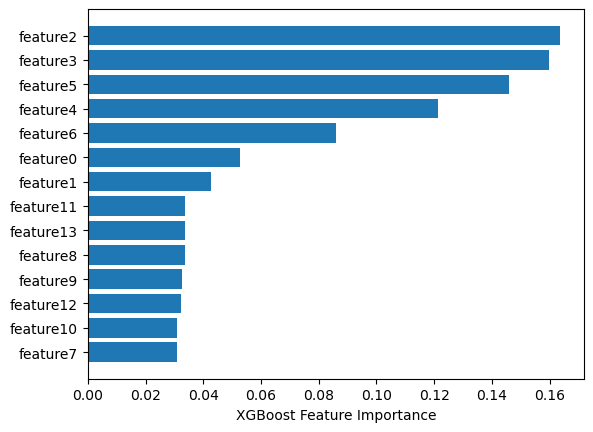

In [11]:
'''
主程式 - 顯示 feature importance
'''
if __name__ == "__main__":
    try:
        # 取得訓練資料
        df = pd.read_csv('./train_jan06_task4bonus.csv')
        imp = KNNImputer(n_neighbors=10, weights='uniform', metric='nan_euclidean')
#         imp = SimpleImputer(strategy='mean')
        X = df.iloc[:, 0:14].values # 0:14
        X = imp.fit_transform(X)
        y = df['class'].values
        
        # 將 label 的順序，從文字轉成數字格式
        Ly = LabelEncoder()
        y = Ly.fit_transform(y)
        print(y)
        print(Ly.classes_)
    
        # 切割資料
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # 初始化模型
        xgb_model = xgb.XGBClassifier(
            objective = 'multi:softprob',
            random_state = 42,
        )
        
        # 訓練
        xgb_model.fit(X_train, y_train)
        
        # 繪圖
#         plt.barh(df.iloc[:, 0:14].columns, xgb_model.feature_importances_)
        
        # 繪圖
        sorted_idx = xgb_model.feature_importances_.argsort()
        plt.barh(df.iloc[:, 0:14].columns[sorted_idx], xgb_model.feature_importances_[sorted_idx])
        plt.xlabel("XGBoost Feature Importance")
        plt.show()
    except Exception as err:
        print(str(err))

In [ ]:
'''
主程式 - 尋找合適的參數
'''
if __name__ == "__main__":
    try:
        # 切割資料
        X, y, X_train, X_test, y_train, y_test, sample_weight_vect_y, sample_weight_vect_y_train, sample_weight_vect_y_test = split_data()

        # 取得最佳參數
        show_best_params(X_train, y_train)
    except Exception as err:
        print(str(err))

[0 0 0 ... 3 3 3]
['A' 'B' 'C' 'D']
(5200, 7)
(8012, 7)
Fitting 10 folds for each of 500 candidates, totalling 5000 fits


[0 0 0 ... 3 3 3]
['A' 'B' 'C' 'D']
(5200, 7)
(8012, 7)
[0]	validation_0-mlogloss:1.32329
[1]	validation_0-mlogloss:1.27246
[2]	validation_0-mlogloss:1.22521
[3]	validation_0-mlogloss:1.18181
[4]	validation_0-mlogloss:1.14361
[5]	validation_0-mlogloss:1.11234
[6]	validation_0-mlogloss:1.08039
[7]	validation_0-mlogloss:1.05224
[8]	validation_0-mlogloss:1.02759
[9]	validation_0-mlogloss:1.00090
[10]	validation_0-mlogloss:0.97795
[11]	validation_0-mlogloss:0.95690
[12]	validation_0-mlogloss:0.93793
[13]	validation_0-mlogloss:0.91987
[14]	validation_0-mlogloss:0.90334
[15]	validation_0-mlogloss:0.88694
[16]	validation_0-mlogloss:0.87129
[17]	validation_0-mlogloss:0.85715
[18]	validation_0-mlogloss:0.84468
[19]	validation_0-mlogloss:0.83242
[20]	validation_0-mlogloss:0.82120
[21]	validation_0-mlogloss:0.81074
[22]	validation_0-mlogloss:0.80117
[23]	validation_0-mlogloss:0.79190
[24]	validation_0-mlogloss:0.78412
[25]	validation_0-mlogloss:0.77603
[26]	validation_0-mlogloss:0.76767
[27]	vali

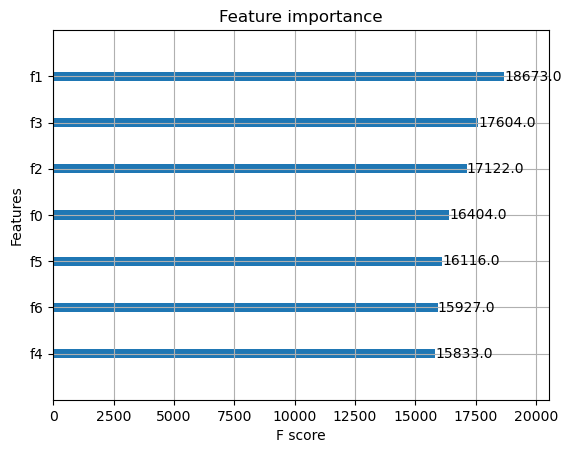

In [30]:
'''
主程式 - 訓練 和 檢視結果，並儲存 model
'''
if __name__ == "__main__":
    try:
        # 切割資料
        XX, y, X_train, X_test, y_train, y_test, sample_weight_vect_y, sample_weight_vect_y_train, sample_weight_vect_y_test = split_data()

        # 訓練模型，並取得測試資料預測結果
        xgb_model, y_pred = train(X_train, X_test, y_train, y_test)

        # 輸出評估結果
        print(f"best score: {xgb_model.best_score}, best iteration: {xgb_model.best_iteration}, best ntree limit {xgb_model.best_ntree_limit}")
        show_scores(xgb_model, X_train, X_test, y_train, y_test, train=True)
        show_scores(xgb_model, X_train, X_test, y_train, y_test, train=False)
        show_feature_importance(xgb_model)
    except Exception as err:
        print(str(err))  

In [31]:
'''
主程式 - 預測結果 與 儲存 submission 用的 csv
'''
if __name__ == "__main__":
    try:
        # 讀取官方所提供的無 label 特徵資料 (test data)，預測結果 (類別) 並儲存成 csv
        predict()
    except Exception as err:
        print(str(err))

        Id Category
0        1        C
1        2        C
2        3        B
3        4        A
4        5        C
...    ...      ...
1595  1596        C
1596  1597        D
1597  1598        D
1598  1599        D
1599  1600        C

[1600 rows x 2 columns]
